# 参数设定

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'
import os
import pickle
import subprocess
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.enable('default', max_rows = None) # 避免警告数据量超过5000
alt.renderers.enable('notebook')

# 基本参数
direction = 'South' # North、South
Fs = 204.8 # 采样频率
start_time = pd.Timestamp('2011-08-06 13:00'); end_time = pd.Timestamp('2011-08-07 05:00')

# 数据和图片保存位置
data_path = 'E:/【论文】/【小论文】/航博/航博数据/Acceleration/%s/' % direction
picture_path0 = 'E:/【论文】/【小论文】/航博/Pictures/Acceleration(%s)/Wind-Acc/' % direction
if not os.path.exists(picture_path0): os.makedirs(picture_path0)

# 用inkscape来转换格式
def convertSVGtoEMF(figname): 
    figname_1 = figname.replace('.svg', '.emf')
    cmd = 'inkscape -z %s -M %s' % (figname, figname_1)
    result = [] # 储存cmd中结果
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        result.append(line)
    errcode = process.returncode 
    for line in result:
        print(line)
    if errcode is not None:
        raise Exception('cmd %s failed, see above for details', cmd)

# Function-判断变量是否已经加载
def if_var_exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

# 加载数据

In [2]:
# 加载wind 已经预留了10分钟的值，到 5:10
method = 2
if method == 2:
    pkl_path = r'E:/【论文】/【小论文】/航博/航博数据/Wind/Wind(East)(AMD)/' # pkl保存位置
if method == 1:
    pkl_path = 'E:/【论文】/【小论文】/航博/航博数据/wind/平均风速法/' # pkl保存位置

if not if_var_exists('data0'):
    with open(pkl_path+'data0.pkl','rb') as f:
        data0 = pickle.load(f)
if not if_var_exists('data1'):
    with open(pkl_path+'data1.pkl','rb') as f:
        data1 = pickle.load(f)

# 加载acc 已经预留了10分钟的值，到 5:10
if not if_var_exists('acc'):
    with open(data_path+'acc_zero.pkl','rb') as f:
        acc = pickle.load(f)

# Mean Wind Speed VS RMS Acceleration

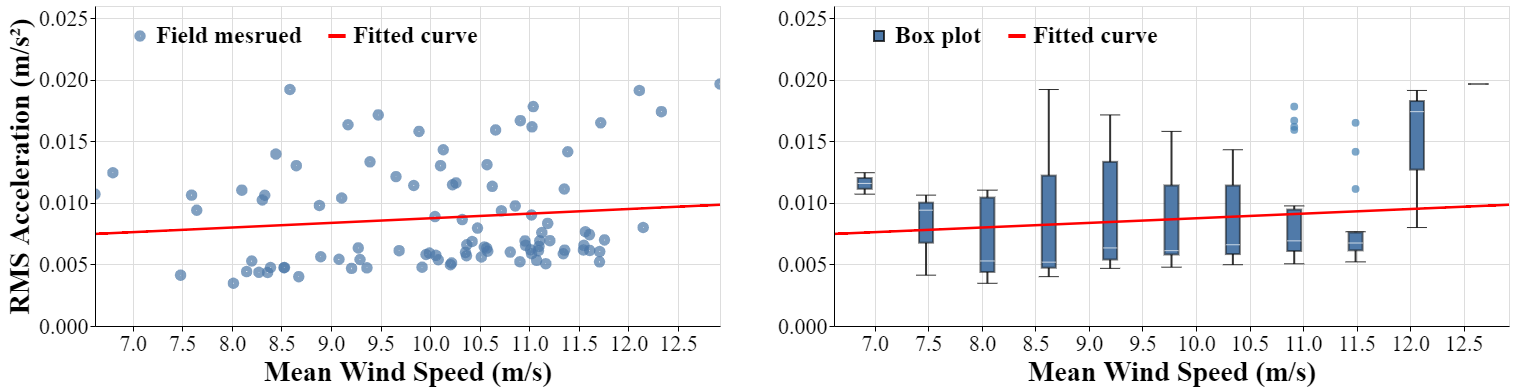

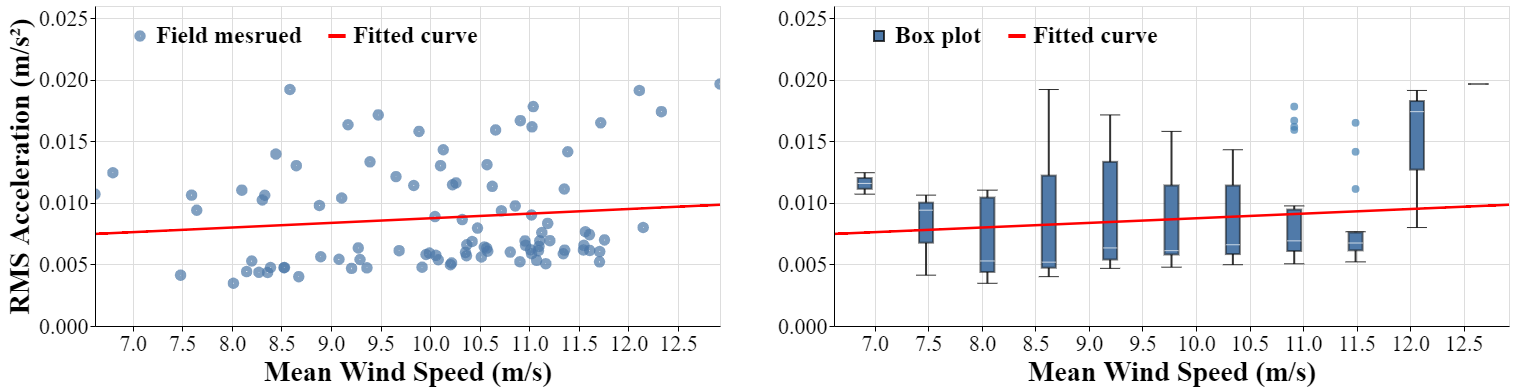

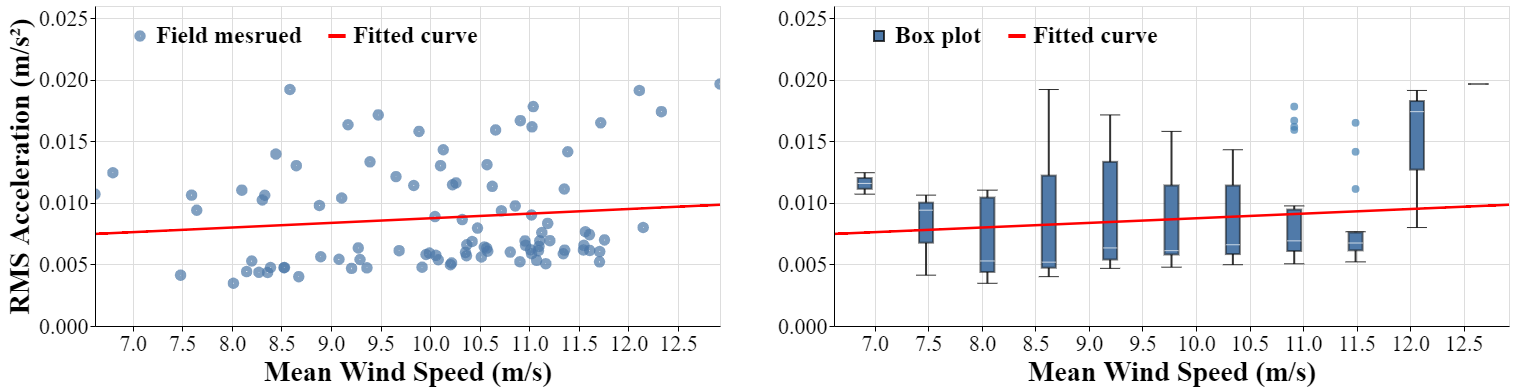

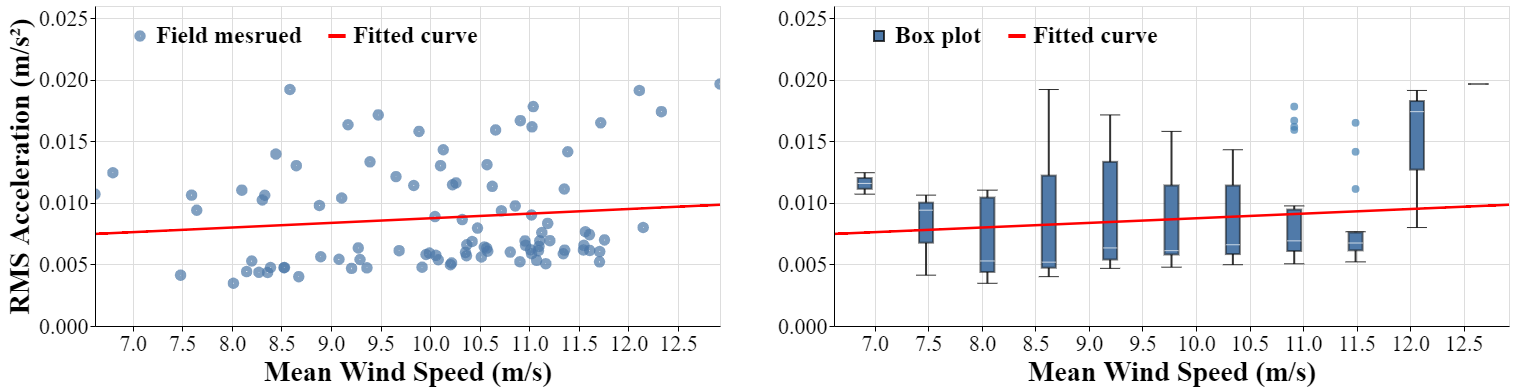

In [10]:
# 选择类型
wind_type = 'uxy'
# Winds
interval = 10 # 分钟
Winds = data0[['uxy_mean','uxy']].resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS.Position1 = RMS.mean(axis=1) ####### 这一步是对五个测点取均值
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Field mesrued']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS = Wind_RMS.reset_index().melt(['index','uxy_mean','uxy'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/ux']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['uxy_mean']<12]

# 拟合
n = 1 # 拟合次数
poly_data = pd.DataFrame({wind_type: np.linspace(Wind_RMS[wind_type].min(), Wind_RMS[wind_type].max(), 10)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS[wind_type], Wind_RMS['RMS'], n))(poly_data[wind_type])
poly_data['legend'] = 'Fitted curve'

# 作图
title_name = 'Variation of RMS Acceleration with Mean Wind Speed (%s)' % (wind_type)
# 点图
Point = (alt
         .Chart(Wind_RMS, title='')
         .mark_point(strokeWidth=6, size=30, clip=True)
         .encode(alt.X('%s:Q'%wind_type, title='Mean Wind Speed (m/s)', 
                       scale=alt.Scale(zero=False, nice=False)),
                 alt.Y('RMS:Q', title='RMS Acceleration (m/s²)'),
                 alt.Color('Position:N', legend=alt.Legend(
                     symbolStrokeWidth=6, symbolSize=30, direction='horizontal', #symbolOffset=-15,
                     values=['Field mesrued'])))
         )
# 拟合曲线
poly_graph = (alt.Chart(poly_data)
              .mark_line(strokeWidth=2.5, color='red')
              .encode(alt.X('%s:Q'%wind_type, title='Mean Wind Speed (m/s)',
                            scale=alt.Scale(zero=False, domain=(Wind_RMS[wind_type].min(),Wind_RMS[wind_type].max()), nice=False)),
                      alt.Y('RMS:Q', scale=alt.Scale(domain=(0,0.025))),
                      alt.Color('legend:N', scale=alt.Scale(range=('red','#4c77a8')),
                                legend=alt.Legend(symbolStrokeWidth=4,symbolSize=300)))
             )
# Box-plot
groups = pd.cut(Wind_RMS[wind_type],11,precision=4)
Wind_RMS1 = Wind_RMS.copy()
Wind_RMS1['variety'] = groups.apply(lambda x: (x.left+x.right)/2)
Wind_RMS1['legend'] = 'Box plot'
Box_plot = (alt
            .Chart(Wind_RMS1)
            .mark_boxplot(ticks=alt.MarkConfig(size=20,opacity=0.8), # extent='min-max',
                          rule=alt.MarkConfig(strokeWidth=2,opacity=0.8),
                          box=alt.MarkConfig(fill='#4682b4',fillOpacity=0.98,stroke='black',strokeWidth=2,strokeOpacity=0.5),
                          outliers=alt.MarkConfig(color='#4682b4',filled=True,size=60))
            .encode(alt.X('variety:N', axis=None), alt.Y('RMS:Q', title=' '), alt.Color('legend:N'))
           )
# 总图
chart = (((Point + poly_graph).properties(width=625,height=320).resolve_scale(color='independent', shape='independent')
          |(Box_plot + poly_graph).properties(width=675,height=320).resolve_scale(color='independent', shape='independent'))
         .configure_axis(titleFontSize=28, labelFontSize=22, labelFont='Times New Roman', titleFont='Times New Roman', domainColor='#000', tickColor='#000')
         .configure_title(font='Times New Roman', fontSize=30)
         .configure_legend(title=None,labelFont='Times New Roman',labelFontSize=24, labelFontWeight='bold',
                           orient='top-left', rowPadding=15, labelLimit=400, symbolOffset=15)
         .resolve_scale(color='independent', shape='independent')
         #.configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart.display()
picture_path1 = picture_path0 + title_name + '.png'
# chart.save(picture_path1, scale_factor=10)

# STD Wind Speed VS RMS Acceleration

## 多图

In [ ]:
# Winds
interval = 1 # 分钟
Winds = data0[['ux','uy','uxy_mean']].resample('%dT'%interval).std()[start_time:end_time]

# RMS
position = 3 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/ux'] = Wind_RMS['Position']/Wind_RMS['ux'] 
Wind_RMS['RMS/uy'] = Wind_RMS['Position']/Wind_RMS['uy'] 
Wind_RMS['RMS/uxy_mean'] = Wind_RMS['Position']/Wind_RMS['uxy_mean'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','ux','RMS/ux','uy','RMS/uy','uxy_mean','RMS/uxy_mean'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/ux']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['uxy_mean']<12]

# 拟合
n = 2 # 拟合次数
poly_data1 = pd.DataFrame({'ux': np.linspace(Wind_RMS['ux'].min(), Wind_RMS['ux'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['ux'], Wind_RMS['RMS'], n))(poly_data1['ux'])
poly_data2 = pd.DataFrame({'uy': np.linspace(Wind_RMS['uy'].min(), Wind_RMS['uy'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['uy'], Wind_RMS['RMS'], n))(poly_data2['uy'])
poly_data3 = pd.DataFrame({'uxy_mean': np.linspace(Wind_RMS['uxy_mean'].min(), Wind_RMS['uxy_mean'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['uxy_mean'], Wind_RMS['RMS'], n))(poly_data3['uxy_mean'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('ux:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('uy:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('uxy_mean:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/ux:Q')
chart12 = base.encode(alt.X('ux:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/uy:Q')
chart22 = base.encode(alt.X('uy:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/uxy_mean:Q')
chart32 = base.encode(alt.X('uxy_mean:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

In [ ]:
# Winds
interval = 10 # 分钟
Winds = data0[['u','v','w']].resample('%dT'%interval).std()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/u'] = Wind_RMS['Position']/Wind_RMS['u'] 
Wind_RMS['RMS/v'] = Wind_RMS['Position']/Wind_RMS['v'] 
Wind_RMS['RMS/w'] = Wind_RMS['Position']/Wind_RMS['w'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','u','RMS/u','v','RMS/v','w','RMS/w'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['u']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/u']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['w']<12]

# 拟合
n = 2 # 拟合次数
poly_data1 = pd.DataFrame({'u': np.linspace(Wind_RMS['u'].min(), Wind_RMS['u'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['u'], Wind_RMS['RMS'], n))(poly_data1['u'])
poly_data2 = pd.DataFrame({'v': np.linspace(Wind_RMS['v'].min(), Wind_RMS['v'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['v'], Wind_RMS['RMS'], n))(poly_data2['v'])
poly_data3 = pd.DataFrame({'w': np.linspace(Wind_RMS['w'].min(), Wind_RMS['w'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['w'], Wind_RMS['RMS'], n))(poly_data3['w'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('u:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('v:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('w:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/u:Q')
chart12 = base.encode(alt.X('u:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/v:Q')
chart22 = base.encode(alt.X('v:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/w:Q')
chart32 = base.encode(alt.X('w:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

In [ ]:
# Winds
interval = 10 # 分钟
Winds = pd.DataFrame([])
Winds['ux'] = data0['ux'] - data0['ux_mean']
Winds['uy'] = data0['uy'] - data0['uy_mean']
Winds['uz'] = data0['uz'] - data0['uz_mean']
Winds = Winds.resample('%dT'%interval).std()[start_time:end_time]

# RMS
position = 3 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/ux'] = Wind_RMS['Position']/Wind_RMS['ux'] 
Wind_RMS['RMS/uy'] = Wind_RMS['Position']/Wind_RMS['uy'] 
Wind_RMS['RMS/uz'] = Wind_RMS['Position']/Wind_RMS['uz'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','ux','RMS/ux','uy','RMS/uy','uz','RMS/uz'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/u']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['uz']<12]

# 拟合
n = 2 # 拟合次数
poly_data1 = pd.DataFrame({'ux': np.linspace(Wind_RMS['ux'].min(), Wind_RMS['ux'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['ux'], Wind_RMS['RMS'], n))(poly_data1['ux'])
poly_data2 = pd.DataFrame({'uy': np.linspace(Wind_RMS['uy'].min(), Wind_RMS['uy'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['uy'], Wind_RMS['RMS'], n))(poly_data2['uy'])
poly_data3 = pd.DataFrame({'uz': np.linspace(Wind_RMS['uz'].min(), Wind_RMS['uz'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['uz'], Wind_RMS['RMS'], n))(poly_data3['uz'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('ux:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('uy:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('uz:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/ux:Q')
chart12 = base.encode(alt.X('ux:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/uy:Q')
chart22 = base.encode(alt.X('uy:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/uz:Q')
chart32 = base.encode(alt.X('uz:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

In [ ]:
## Winds
interval = 10 # 分钟
Winds0 = data0[['u','v','w']]
Angle = data0['Angle']
Winds=pd.DataFrame([])
Winds['u'] = Winds0.u * np.sin(np.deg2rad(Angle)) + Winds0.v * np.cos(np.deg2rad(Angle))
Winds['v'] = Winds0.u * np.cos(np.deg2rad(Angle)) - Winds0.v * np.sin(np.deg2rad(Angle))
Winds['w'] = Winds0.w
Winds = Winds.resample('%dT'%interval).std()[start_time:end_time]

# RMS
position = 3 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/u'] = Wind_RMS['Position']/Wind_RMS['u'] 
Wind_RMS['RMS/v'] = Wind_RMS['Position']/Wind_RMS['v'] 
Wind_RMS['RMS/w'] = Wind_RMS['Position']/Wind_RMS['w'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','u','RMS/u','v','RMS/v','w','RMS/w'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['u']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/u']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['w']<12]

# 拟合
n = 2 # 拟合次数
poly_data1 = pd.DataFrame({'u': np.linspace(Wind_RMS['u'].min(), Wind_RMS['u'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['u'], Wind_RMS['RMS'], n))(poly_data1['u'])
poly_data2 = pd.DataFrame({'v': np.linspace(Wind_RMS['v'].min(), Wind_RMS['v'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['v'], Wind_RMS['RMS'], n))(poly_data2['v'])
poly_data3 = pd.DataFrame({'w': np.linspace(Wind_RMS['w'].min(), Wind_RMS['w'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['w'], Wind_RMS['RMS'], n))(poly_data3['w'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('u:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('v:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('w:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/u:Q')
chart12 = base.encode(alt.X('u:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/v:Q')
chart22 = base.encode(alt.X('v:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/w:Q')
chart32 = base.encode(alt.X('w:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

## 单张图

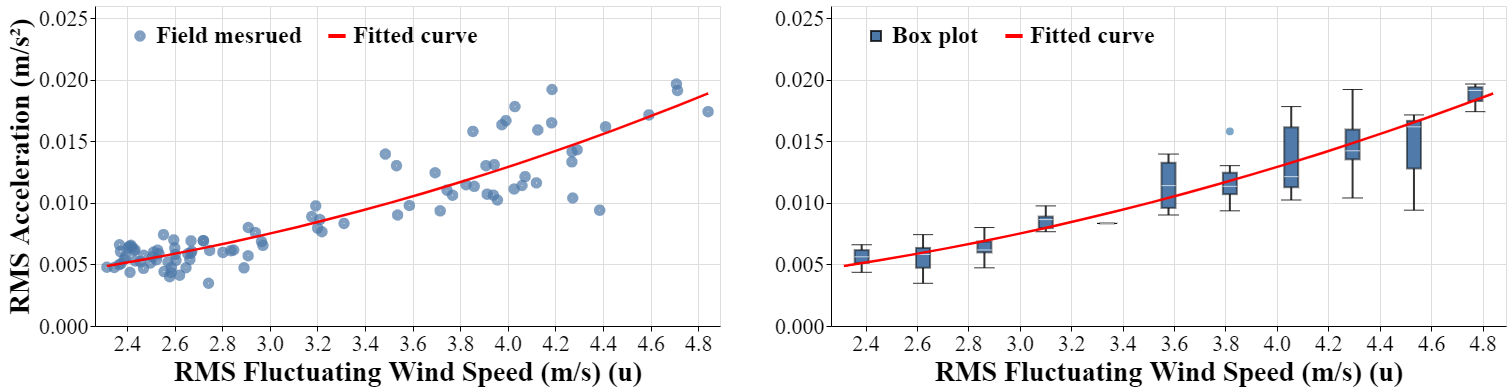

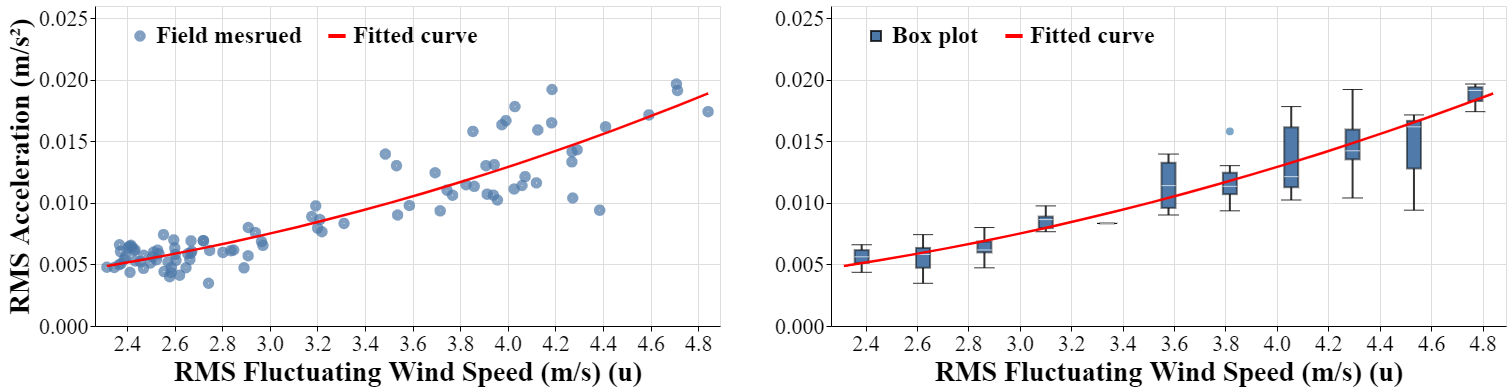

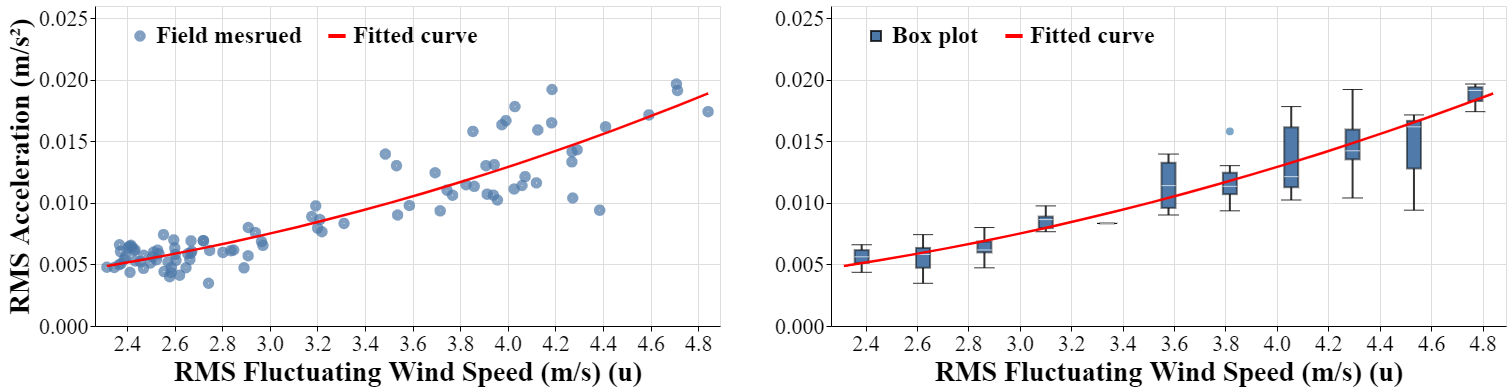

In [5]:
# 选择类型
wind_type = 'u'
# Winds
interval = 10 # 分钟
Winds = data0[['u','v','w']].resample('%dT'%interval).std()[start_time:end_time]

# ## Winds
# interval = 10 # 分钟
# Winds0 = data0[['u','v','w']]
# Angle = data0['Angle']
# Winds=pd.DataFrame([])
# Winds['u'] = Winds0.u * np.sin(np.deg2rad(Angle)) + Winds0.v * np.cos(np.deg2rad(Angle))
# Winds['v'] = Winds0.u * np.cos(np.deg2rad(Angle)) - Winds0.v * np.sin(np.deg2rad(Angle))
# Winds['w'] = Winds0.w
# Winds = Winds.resample('%dT'%interval).std()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()[start_time:end_time]
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS.Position1 = RMS.mean(axis=1) ####### 这一步是对五个测点取均值
RMS = RMS[['Position%d'%position]]
RMS.columns = ['Field mesrued']

# Wind_RMS
Wind_RMS = pd.concat([Winds,RMS],axis=1)
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS = Wind_RMS.reset_index().melt(['index','u','v','w'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/ux']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['u']<12]

# 拟合
n = 2 # 拟合次数
poly_data = pd.DataFrame({wind_type: np.linspace(Wind_RMS[wind_type].min(), Wind_RMS[wind_type].max(), 20)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS[wind_type], Wind_RMS['RMS'], n))(poly_data[wind_type])
poly_data['legend'] = 'Fitted curve'

# # 给出拟合公式
# slope = np.polyfit(Wind_RMS[wind_type], Wind_RMS['RMS'], n)
# print('RMS_Acceleration = %f RMS_Wind_%s² + %f RMS_Wind_%s + %f'%(slope[0],wind_type,slope[1],wind_type,slope[2]))

# 作图
title_name = 'Variation of RMS Acceleration with RMS Fluctuating Wind Speed (%s)' % (wind_type)
# 点图
Point = (alt
         .Chart(Wind_RMS, title='')
         .mark_point(strokeWidth=6, size=30, clip=True)
         .encode(alt.X('%s:Q' % wind_type, scale=alt.Scale(zero=False, nice=False)),
                 alt.Y('RMS:Q', title='RMS Acceleration (m/s²)'),
                 alt.Color('Position:N', legend=alt.Legend(
                     symbolStrokeWidth=6, symbolSize=30, direction='horizontal', #symbolOffset=-15,
                     values=['Field mesrued'])))
         )
# 拟合曲线
poly_graph = (alt.Chart(poly_data)
              .mark_line(strokeWidth=2.5)
              .encode(alt.X('%s:Q' % wind_type, title='RMS Fluctuating Wind Speed (m/s) (%s)' % wind_type,
                            axis=alt.Axis(tickMinStep=0.2), scale=alt.Scale(zero=False,
                            domain=(Wind_RMS[wind_type].min()-0.05, Wind_RMS[wind_type].max()+0.05), nice=False)),
                      alt.Y('RMS:Q', scale=alt.Scale(zero=False, domain=(0,0.025))),
                      alt.Color('legend:N', scale=alt.Scale(range=('red','#4c77a8')),
                                legend=alt.Legend(symbolStrokeWidth=4,symbolSize=300)))
             )
# Box-plot
groups = pd.cut(Wind_RMS[wind_type],11,precision=4)
Wind_RMS1 = Wind_RMS.copy()
Wind_RMS1['variety'] = groups.apply(lambda x: (x.left+x.right)/2)
Wind_RMS1['legend'] = 'Box plot'
Box_plot = (alt
            .Chart(Wind_RMS1)
            .mark_boxplot(ticks=alt.MarkConfig(size=20,opacity=0.8), # extent='min-max',
                          rule=alt.MarkConfig(strokeWidth=2,opacity=0.8),
                          box=alt.MarkConfig(fill='#4682b4',fillOpacity=0.98,stroke='black',strokeWidth=2,strokeOpacity=0.5),
                          outliers=alt.MarkConfig(color='#4682b4',filled=True,size=60))
            .encode(alt.X('variety:N', axis=None), alt.Y('RMS:Q', title=' '), alt.Color('legend:N'))
           )
# 总图
chart = (((Point + poly_graph).properties(width=625,height=320).resolve_scale(color='independent', shape='independent')
          |(Box_plot + poly_graph).properties(width=675,height=320).resolve_scale(color='independent', shape='independent'))
         .configure_axis(titleFontSize=28, labelFontSize=22, labelFont='Times New Roman', titleFont='Times New Roman', domainColor='#000', tickColor='#000')
         .configure_title(font='Times New Roman', fontSize=30)
         .configure_legend(title=None,labelFont='Times New Roman',labelFontSize=24, labelFontWeight='bold',
                           orient='top-left', rowPadding=15, labelLimit=400, symbolOffset=15)
         .resolve_scale(color='independent', shape='independent')
         #.configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart.display()
picture_path1 = picture_path0 + title_name + '.png'
# chart.save(picture_path1, scale_factor=10)

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
 
#构造变量
 
#建回归方程
#OLS（endog,exog=None,missing='none',hasconst=None) (endog:因变量，exog=自变量）
x=Wind_RMS['u']
y=Wind_RMS['RMS']
modle=sm.OLS(y,x) #最小二乘法
res=modle.fit() #拟合数据
Bata=res.params  #取系数


In [ ]:
Y=res.fittedvalues  #预测值
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x, y, 'o', label='data')#原始数据
ax.plot(x, Y, 'r--.',label='test')#拟合数据
ax.legend(loc='best') #展示各点表示意思，即label
plt.show()


## Error_bars

In [ ]:
groups = pd.cut(Wind_RMS[wind_type],11,precision=0)
Wind_RMS1=Wind_RMS.copy()
Wind_RMS1['variety'] = groups.apply(lambda x: x.left)
point = (alt.
        Chart(Wind_RMS1)
        .mark_point(filled=True,size=45,color='black')
        .encode(
            x=alt.X('variety:N',axis=None),
            y=alt.Y('mean(RMS):Q', scale=alt.Scale(zero=False)))
        )
Error_bars = (alt
              .Chart(Wind_RMS1)
              .mark_errorbar(extent='ci',
                             ticks=alt.MarkConfig(color='black',strokeWidth=1,size=9),
                             rule=alt.MarkConfig(strokeWidth=1,opacity=1),
                            )
              .encode(
                  x=alt.X('variety:N',axis=None),
                  y=alt.Y('RMS:Q', scale=alt.Scale(zero=False)))
             )
chart = ((Error_bars + point + poly_graph)
         .configure_axis(grid=True, titleFontSize=24, labelFontSize=18, labelFont='Times New Roman', titleFont='Times New Roman')
         .configure_title(font='Times New Roman', fontSize=30)
         .properties(width=1111)
#          .configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart

# Turbulence_intensity & Acc RMS

## 多图

In [ ]:
# Turbulence_intensity
interval = 10 # 分钟
Turbulence_intensity = data1['turbulence_intensity'].resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Turbulence_intensity,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/turbulence_intensity_u'] = Wind_RMS['Position']/Wind_RMS['turbulence_intensity_u'] 
Wind_RMS['RMS/turbulence_intensity_v'] = Wind_RMS['Position']/Wind_RMS['turbulence_intensity_v'] 
Wind_RMS['RMS/turbulence_intensity_w'] = Wind_RMS['Position']/Wind_RMS['turbulence_intensity_w'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','turbulence_intensity_u','RMS/turbulence_intensity_u','turbulence_intensity_v','RMS/turbulence_intensity_v','turbulence_intensity_w','RMS/turbulence_intensity_w'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['turbulence_intensity_u']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/turbulence_intensity_u']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['turbulence_intensity_w']<12]

# 拟合
n = 1 # 拟合次数
poly_data1 = pd.DataFrame({'turbulence_intensity_u': np.linspace(Wind_RMS['turbulence_intensity_u'].min(), Wind_RMS['turbulence_intensity_u'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['turbulence_intensity_u'], Wind_RMS['RMS'], n))(poly_data1['turbulence_intensity_u'])
poly_data2 = pd.DataFrame({'turbulence_intensity_v': np.linspace(Wind_RMS['turbulence_intensity_v'].min(), Wind_RMS['turbulence_intensity_v'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['turbulence_intensity_v'], Wind_RMS['RMS'], n))(poly_data2['turbulence_intensity_v'])
poly_data3 = pd.DataFrame({'turbulence_intensity_w': np.linspace(Wind_RMS['turbulence_intensity_w'].min(), Wind_RMS['turbulence_intensity_w'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['turbulence_intensity_w'], Wind_RMS['RMS'], n))(poly_data3['turbulence_intensity_w'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('turbulence_intensity_u:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('turbulence_intensity_v:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('turbulence_intensity_w:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/turbulence_intensity_u:Q')
chart12 = base.encode(alt.X('turbulence_intensity_u:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/turbulence_intensity_v:Q')
chart22 = base.encode(alt.X('turbulence_intensity_v:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/turbulence_intensity_w:Q')
chart32 = base.encode(alt.X('turbulence_intensity_w:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

## 单张图

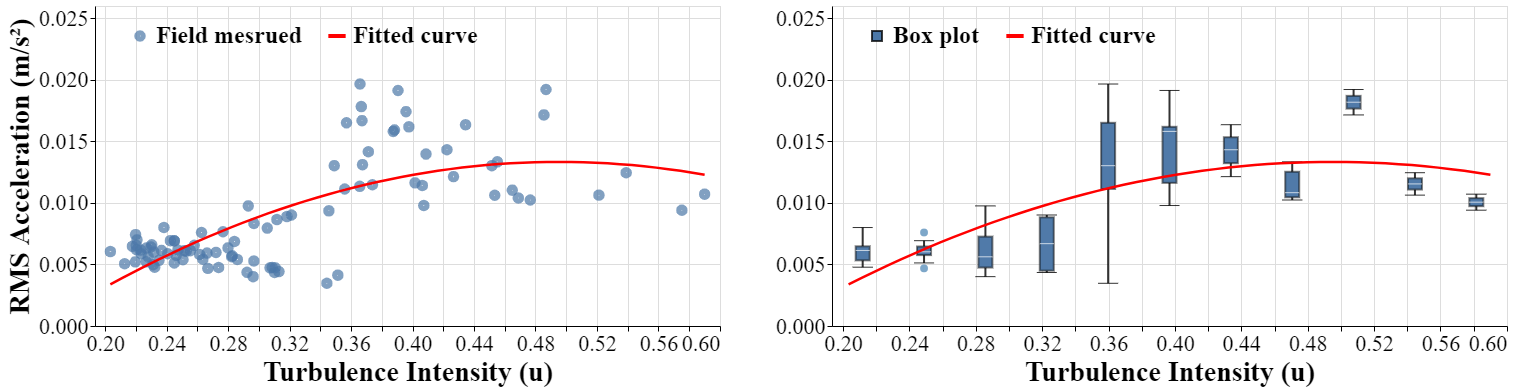

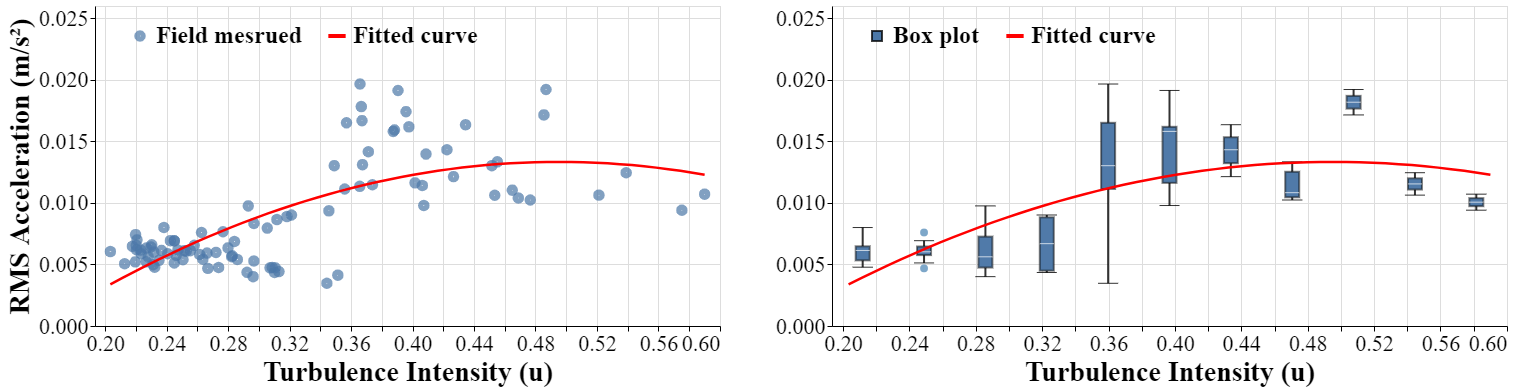

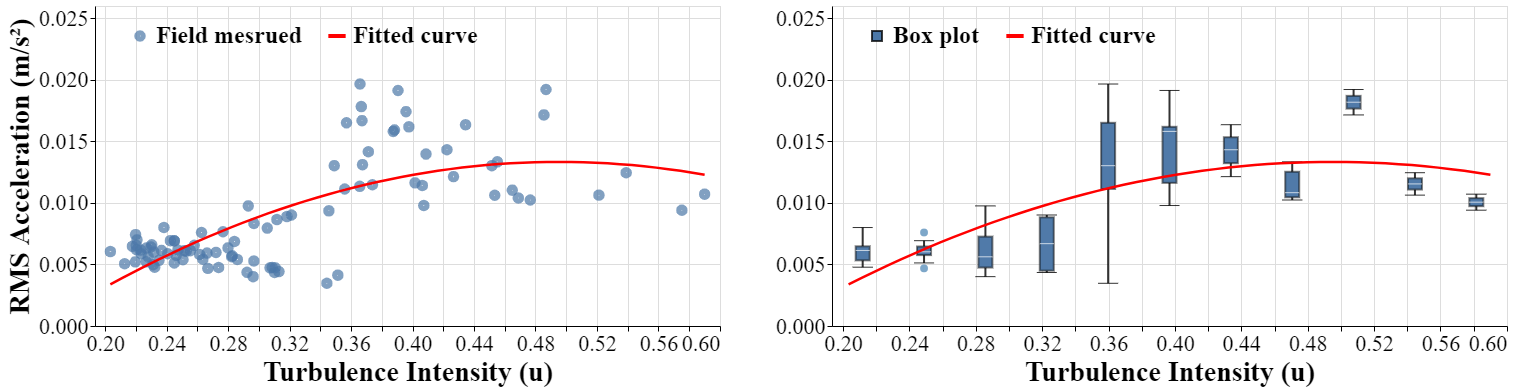

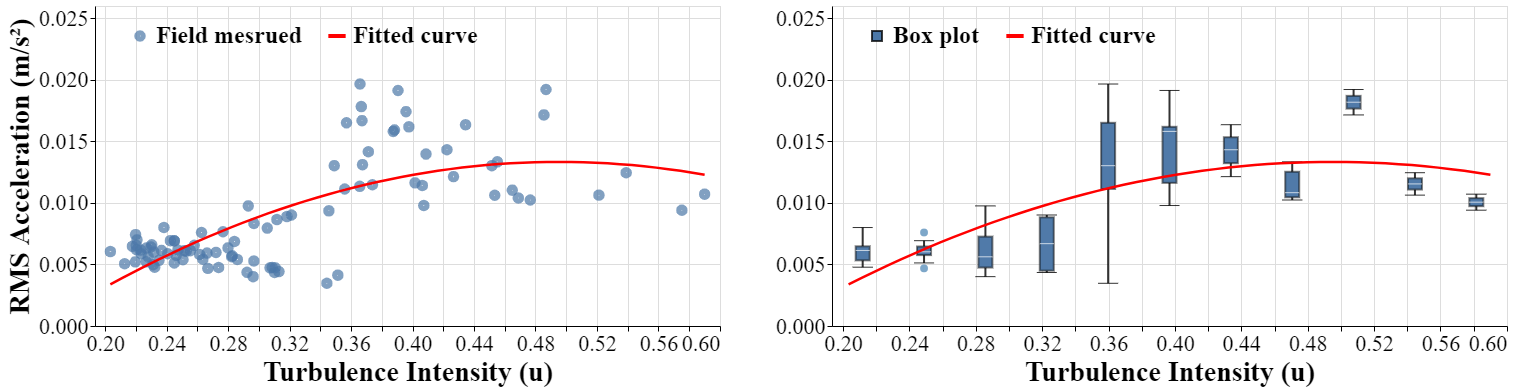

In [5]:
# 选择类型
wind_type0 = 'u'
wind_type = 'turbulence_intensity_%s' % wind_type0
# Turbulence_intensity
interval = 10 # 分钟
Turbulence_intensity = data1['turbulence_intensity'].resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()[start_time:end_time]
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS.Position1 = RMS.mean(axis=1) ####### 这一步是对五个测点取均值
RMS = RMS[['Position%d'%position]]
RMS.columns = ['Field mesrued']

# Wind_RMS
Wind_RMS = pd.concat([Turbulence_intensity,RMS],axis=1)
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS = Wind_RMS.reset_index().melt(['index','turbulence_intensity_u','turbulence_intensity_v','turbulence_intensity_w'],
                                       var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/ux']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['u']<12]

# 拟合
n = 2 # 拟合次数
poly_data = pd.DataFrame({wind_type: np.linspace(Wind_RMS[wind_type].min(), Wind_RMS[wind_type].max(), 50)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS[wind_type], Wind_RMS['RMS'], n))(poly_data[wind_type])
poly_data['legend'] = 'Fitted curve'

# 作图
title_name = 'Variation of RMS Acceleration with Turbulence Intensity (%s)' % (wind_type0)
# 点图
Point = (alt
         .Chart(Wind_RMS, title='')
         .mark_point(strokeWidth=6, size=30, clip=True)
         .encode(alt.X('%s:Q'%wind_type, title='Turbulence Intensity (%s)' % wind_type0,
                       scale=alt.Scale(zero=False, nice=False)),
                 alt.Y('RMS:Q', title='RMS Acceleration (m/s²)'),
                 alt.Color('Position:N', legend=alt.Legend(
                     symbolStrokeWidth=6, symbolSize=30, direction='horizontal', #symbolOffset=-15,
                     values=['Field mesrued'])))
         )
# 拟合曲线
poly_graph = (alt.Chart(poly_data)
              .mark_line(strokeWidth=2.5)
              .encode(alt.X('%s:Q'%wind_type, title='Turbulence Intensity (%s)' % wind_type0,
                            scale=alt.Scale(zero=False,
                            domain=(Wind_RMS[wind_type].min()-0.01, Wind_RMS[wind_type].max()+0.01), nice=False)),
                      alt.Y('RMS:Q', scale=alt.Scale(zero=False, domain=(0,0.025))),
                      alt.Color('legend:N', scale=alt.Scale(range=('red','#4c77a8')),
                                legend=alt.Legend(symbolStrokeWidth=4,symbolSize=300)))
             )
# Box-plot
groups = pd.cut(Wind_RMS[wind_type],11,precision=4)
Wind_RMS1 = Wind_RMS.copy()
Wind_RMS1['variety'] = groups.apply(lambda x: (x.left+x.right)/2)
Wind_RMS1['legend'] = 'Box plot'
Box_plot = (alt
            .Chart(Wind_RMS1)
            .mark_boxplot(ticks=alt.MarkConfig(size=20,opacity=0.8), # extent='min-max',
                          rule=alt.MarkConfig(strokeWidth=2,opacity=0.8),
                          box=alt.MarkConfig(fill='#4682b4',fillOpacity=0.98,stroke='black',strokeWidth=2,strokeOpacity=0.5),
                          outliers=alt.MarkConfig(color='#4682b4',filled=True,size=60))
            .encode(alt.X('variety:N', axis=None), alt.Y('RMS:Q', title=' '), alt.Color('legend:N'))
           )
# 总图9
chart = (((Point + poly_graph).properties(width=625,height=320).resolve_scale(color='independent', shape='independent')
          |(Box_plot + poly_graph).properties(width=675,height=320).resolve_scale(color='independent', shape='independent'))
         .configure_axis(titleFontSize=28, labelFontSize=22, labelFont='Times New Roman', titleFont='Times New Roman', domainColor='#000', tickColor='#000')
         .configure_title(font='Times New Roman', fontSize=30)
         .configure_legend(title=None,labelFont='Times New Roman',labelFontSize=24, labelFontWeight='bold',
                           orient='top-left', rowPadding=15, labelLimit=400, symbolOffset=15)
         .resolve_scale(color='independent', shape='independent')
         #.configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart.display()
picture_path1 = picture_path0 + title_name + '.png'
# chart.save(picture_path1, scale_factor=10)

# Gust_factor & Acc RMS

## 多图

In [ ]:
# Gust_factor
interval = 10 # 分钟
Gust_factor = data1['gust_factor'].resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]
RMS.columns = ['Position']

# Wind_RMS
Wind_RMS = pd.concat([Gust_factor,RMS],axis=1)
chart0 = alt.Chart(Wind_RMS.reset_index()).mark_point().properties(width=1111,height=400).encode(x=alt.X('index:T', title=None),y='Position')
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS['RMS/gust_factor_u'] = Wind_RMS['Position']/Wind_RMS['gust_factor_u'] 
Wind_RMS['RMS/gust_factor_v'] = Wind_RMS['Position']/Wind_RMS['gust_factor_v'] 
Wind_RMS['RMS/gust_factor_w'] = Wind_RMS['Position']/Wind_RMS['gust_factor_w'] 
Wind_RMS = Wind_RMS.reset_index().melt(['index','gust_factor_u','RMS/gust_factor_u','gust_factor_v','RMS/gust_factor_v','gust_factor_w','RMS/gust_factor_w'], var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['gust_factor_u']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/gust_factor_u']>-10]
Wind_RMS = Wind_RMS[Wind_RMS['gust_factor_w']<1]

# 拟合
n = 1 # 拟合次数
poly_data1 = pd.DataFrame({'gust_factor_u': np.linspace(Wind_RMS['gust_factor_u'].min(), Wind_RMS['gust_factor_u'].max(), 100)})
poly_data1['RMS'] = np.poly1d(np.polyfit(Wind_RMS['gust_factor_u'], Wind_RMS['RMS'], n))(poly_data1['gust_factor_u'])
poly_data2 = pd.DataFrame({'gust_factor_v': np.linspace(Wind_RMS['gust_factor_v'].min(), Wind_RMS['gust_factor_v'].max(), 100)})
poly_data2['RMS'] = np.poly1d(np.polyfit(Wind_RMS['gust_factor_v'], Wind_RMS['RMS'], n))(poly_data2['gust_factor_v'])
poly_data3 = pd.DataFrame({'gust_factor_w': np.linspace(Wind_RMS['gust_factor_w'].min(), Wind_RMS['gust_factor_w'].max(), 100)})
poly_data3['RMS'] = np.poly1d(np.polyfit(Wind_RMS['gust_factor_w'], Wind_RMS['RMS'], n))(poly_data3['gust_factor_w'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point(size=8).encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=320,height=150)

poly_graph1 = alt.Chart(poly_data1).mark_line().encode(
    alt.X('gust_factor_u:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph2 = alt.Chart(poly_data2).mark_line().encode(
    alt.X('gust_factor_v:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
poly_graph3 = alt.Chart(poly_data3).mark_line().encode(
    alt.X('gust_factor_w:Q', scale=alt.Scale(zero = False)),y='RMS:Q')

chart00 = base.encode(x=alt.X('index:T', title=None),y='RMS:Q').properties(width=1111,height=400)
chart11 = base.encode(x=alt.X('index:T', title=None),y='RMS/gust_factor_u:Q')
chart12 = base.encode(alt.X('gust_factor_u:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph1
chart21 = base.encode(x=alt.X('index:T', title=None),y='RMS/gust_factor_v:Q')
chart22 = base.encode(alt.X('gust_factor_v:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph2
chart31 = base.encode(x=alt.X('index:T', title=None),y='RMS/gust_factor_w:Q')
chart32 = base.encode(alt.X('gust_factor_w:Q', scale=alt.Scale(zero = False)),y='RMS:Q') + poly_graph3

chart00 & ( (chart11 & chart12) | (chart21 & chart22) | (chart31 & chart32) )

## 单张图

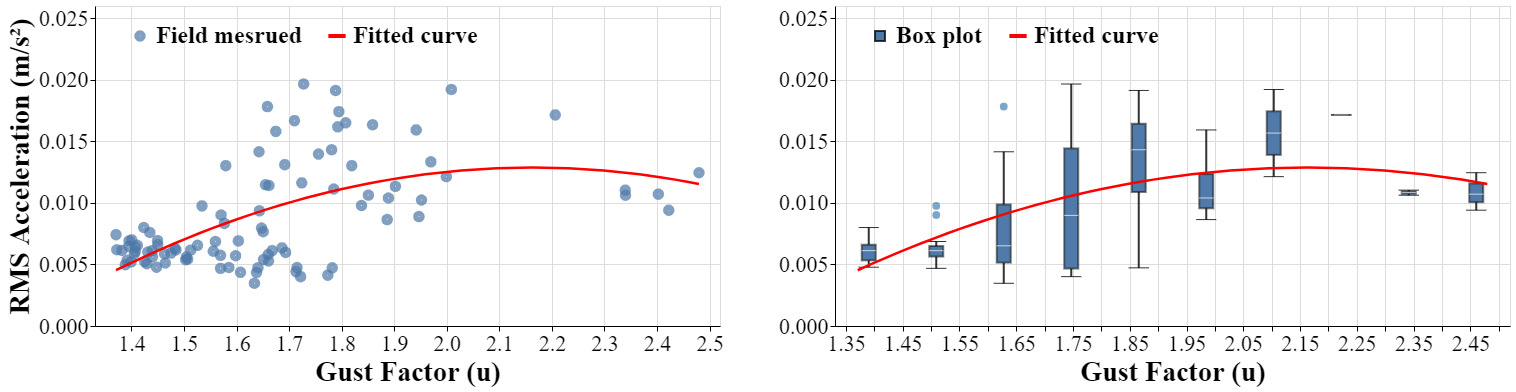

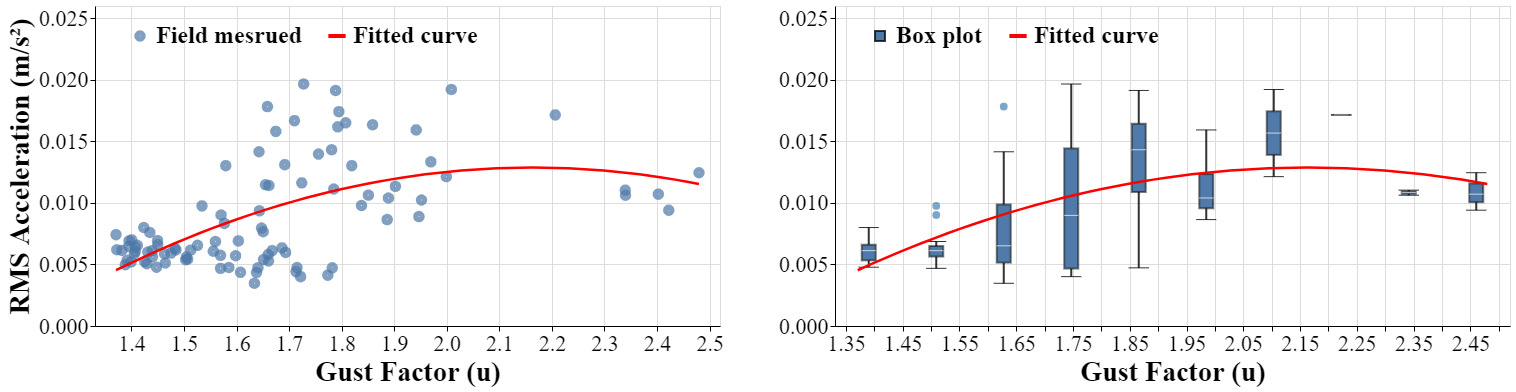

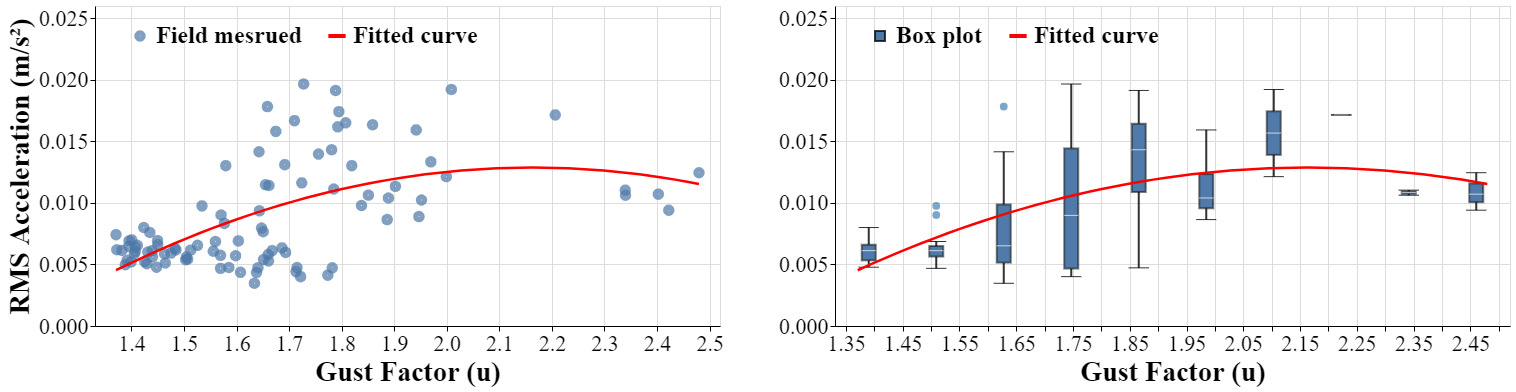

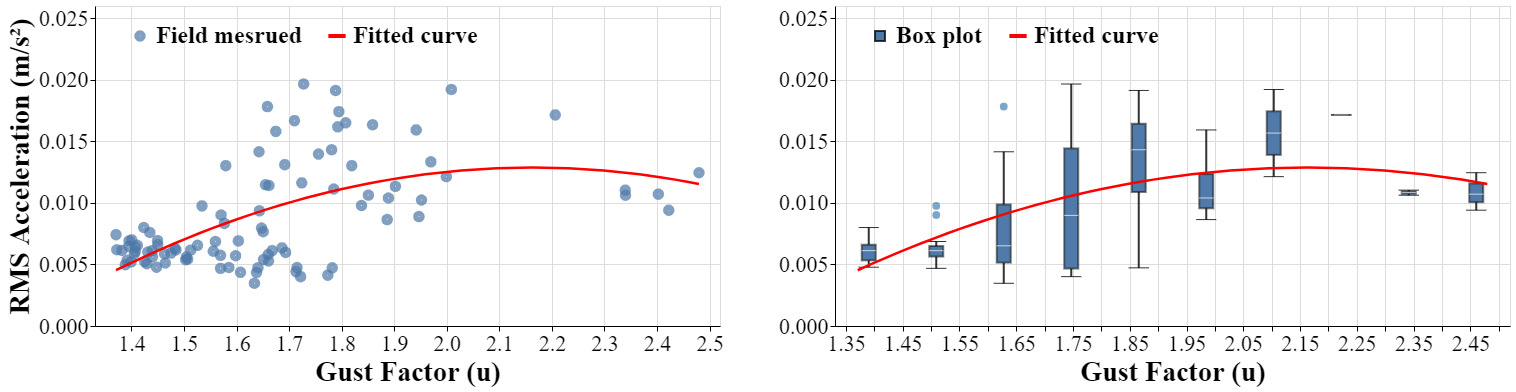

In [6]:
# 选择类型
wind_type0 = 'u'
wind_type = 'gust_factor_%s' % wind_type0
# Gust_factor
interval = 10 # 分钟
Gust_factor = data1['gust_factor'].resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()[start_time:end_time]
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS.Position1 = RMS.mean(axis=1) ####### 这一步是对五个测点取均值
RMS = RMS[['Position%d'%position]]
RMS.columns = ['Field mesrued']

# Wind_RMS
Wind_RMS = pd.concat([Gust_factor,RMS],axis=1)
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 05:00'] # 框定时间范围
Wind_RMS = Wind_RMS.reset_index().melt(['index','gust_factor_u','gust_factor_v','gust_factor_w'],
                                       var_name='Position', value_name='RMS')

# 取舍
# Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.04]
# Wind_RMS = Wind_RMS[Wind_RMS['ux']<5]
# Wind_RMS = Wind_RMS[Wind_RMS['RMS/ux']>-10]
# Wind_RMS = Wind_RMS[Wind_RMS['u']<12]

# 拟合
n = 2 # 拟合次数
poly_data = pd.DataFrame({wind_type: np.linspace(Wind_RMS[wind_type].min(), Wind_RMS[wind_type].max(), 50)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS[wind_type], Wind_RMS['RMS'], n))(poly_data[wind_type])
poly_data['legend'] = 'Fitted curve'

# 作图
title_name = 'Variation of RMS Acceleration with Gust Factor (%s)' % (wind_type0)
# 点图
Point = (alt
         .Chart(Wind_RMS, title='')
         .mark_point(strokeWidth=6, size=30, clip=True)
         .encode(alt.X('%s:Q'%wind_type, title='Gust Factor (%s)' % wind_type0,
                       scale=alt.Scale(zero=False, nice=False)),
                 alt.Y('RMS:Q', title='RMS Acceleration (m/s²)'),
                 alt.Color('Position:N', legend=alt.Legend(
                     symbolStrokeWidth=6, symbolSize=30, direction='horizontal', #symbolOffset=-15,
                     values=['Field mesrued'])))
         )
# 拟合曲线
poly_graph = (alt.Chart(poly_data)
              .mark_line(strokeWidth=2.5)
              .encode(alt.X('%s:Q'%wind_type, title='Gust Factor (%s)' % wind_type0,
                            scale=alt.Scale(zero=False,
                            domain=(Wind_RMS[wind_type].min()-0.04, Wind_RMS[wind_type].max()+0.04), nice=False)),
                      alt.Y('RMS:Q', scale=alt.Scale(zero=False, domain=(0,0.025))),
                      alt.Color('legend:N', scale=alt.Scale(range=('red','#4c77a8')),
                                legend=alt.Legend(symbolStrokeWidth=4,symbolSize=300)))
             )
# Box-plot
groups = pd.cut(Wind_RMS[wind_type],11,precision=4)
Wind_RMS1 = Wind_RMS.copy()
Wind_RMS1['variety'] = groups.apply(lambda x: (x.left+x.right)/2)
Wind_RMS1['legend'] = 'Box plot'
Box_plot = (alt
            .Chart(Wind_RMS1)
            .mark_boxplot(ticks=alt.MarkConfig(size=20,opacity=0.8), # extent='min-max',
                          rule=alt.MarkConfig(strokeWidth=2,opacity=0.8),
                          box=alt.MarkConfig(fill='#4682b4',fillOpacity=0.98,stroke='black',strokeWidth=2,strokeOpacity=0.5),
                          outliers=alt.MarkConfig(color='#4682b4',filled=True,size=60))
            .encode(alt.X('variety:N', axis=None), alt.Y('RMS:Q', title=' '), alt.Color('legend:N'))
           )
# 总图9
chart = (((Point + poly_graph).properties(width=625,height=320).resolve_scale(color='independent', shape='independent')
          |(Box_plot + poly_graph).properties(width=675,height=320).resolve_scale(color='independent', shape='independent'))
         .configure_axis(titleFontSize=28, labelFontSize=22, labelFont='Times New Roman', titleFont='Times New Roman', domainColor='#000', tickColor='#000')
         .configure_title(font='Times New Roman', fontSize=30)
         .configure_legend(title=None,labelFont='Times New Roman',labelFontSize=24, labelFontWeight='bold',
                           orient='top-left', rowPadding=15, labelLimit=400, symbolOffset=15)
         .resolve_scale(color='independent', shape='independent')
         #.configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart.display()
picture_path1 = picture_path0 + title_name + '.png'
# chart.save(picture_path1, scale_factor=10)

# Wind Direction & Acc RMS

## 多图

In [ ]:
# Winds
interval = 1 # 分钟
Winds = data0[['Angle']]
Winds[Winds>100] = (360 - Winds[Winds>100]).values
Winds = Winds.resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]

# Wind_RMS
Wind_RMS = pd.concat([Winds['Angle'],RMS],axis=1)
Wind_RMS = Wind_RMS['2011-08-06 13:00':'2011-08-07 5:00'] # 框定时间范围
Wind_RMS = Wind_RMS.reset_index()
Wind_RMS = Wind_RMS.melt(['index','Angle'], var_name='Position', value_name='RMS')

# 取舍
Wind_RMS = Wind_RMS[Wind_RMS['RMS']<0.036]
# Wind_RMS = Wind_RMS[Wind_RMS['Angle']<13.5]

# 拟合
poly_data = pd.DataFrame({'Angle': np.linspace(Wind_RMS['Angle'].min(), Wind_RMS['Angle'].max(), 100)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS['Angle'], Wind_RMS['RMS'], 2))(poly_data['Angle'])

# 画图
brush = alt.selection(type='interval')
base = alt.Chart(Wind_RMS).mark_point().encode(
    color=alt.condition(brush, 'Position', alt.ColorValue('lightgray')) # #00000000
).add_selection(brush).properties(width=500,height=250)

poly_graph = alt.Chart(poly_data).mark_line().encode(alt.X('Angle:Q',scale=alt.Scale(zero=False)),y='RMS:Q')

chart1 = base.encode(alt.X('index:T',title=None),y='RMS:Q')#.interactive(bind_x = False) # 交互性设置
chart2 = base.encode(alt.X('Angle:Q',title='Wind direction',scale=alt.Scale(zero=False)),y='RMS:Q') + poly_graph

chart1 | chart2

## 单张图

In [ ]:
# Winds
interval = 1 # 分钟
Winds = data0[['Angle']]
Winds[Winds>100] = 360 - Winds[Winds>100]
Winds = Winds.resample('%dT'%interval).mean()[start_time:end_time]

# RMS
position = 1 # 测点位置
RMS = acc.resample('%dT'%interval).std()
RMS.columns = ['Position1','Position2','Position3','Position4','Position5']
RMS = RMS[start_time:end_time][['Position%d'%position]]

# Wind_RMS
Wind_RMS = pd.concat([Winds['Angle'],RMS],axis=1)
Wind_RMS = Wind_RMS.melt('Angle', var_name='Position', value_name='RMS')

# 拟合
n = 2 # 拟合次数
poly_data = pd.DataFrame({'Angle': np.linspace(Wind_RMS['Angle'].min(), Wind_RMS['Angle'].max(), 100)})
poly_data['RMS'] = np.poly1d(np.polyfit(Wind_RMS['Angle'], Wind_RMS['RMS'], n))(poly_data['Angle'])

# 作图
title_name = 'Variation of Vibration RMS with Wind Direction (%s)' % wind_type
base = (alt
         .Chart(Wind_RMS, title=title_name)
         .mark_point(strokeWidth=1.5)
         .encode(alt.X('Angle:Q', title='Average Wind Direction', scale=alt.Scale(zero=False)),
                 alt.Y('RMS:Q', title='Wind-induced Response RMS (m/s²)'),
                 alt.Color('Position:N', 
                           legend=alt.Legend(
                               title=None, orient='top-left', rowPadding=7, titlePadding=10,
                               labelFont='Times New Roman',labelFontSize=18, labelLimit=400,
                               titleFont='Times New Roman', titleFontSize=16)))
       )
poly_graph = alt.Chart(poly_data).mark_line().encode(alt.X('Angle:Q', scale=alt.Scale(zero = False)),y='RMS:Q')
chart = ((base + poly_graph)
         .configure_axis(grid=False, titleFontSize=24, labelFontSize=18, labelFont='Times New Roman', titleFont='Times New Roman')
         .configure_title(font='Times New Roman', fontSize=30)
         .properties(width=1111)
         .configure_view(stroke='#000') # 黑色外边框，需设置grid=False才能看到
        )
chart.display()
# picture_path1 = picture_path0 + title_name + '.png'
# chart.save(picture_path1, scale_factor=10)

# 学习+试验

In [ ]:
import altair as alt
import pandas as pd
import numpy as np

# generate some data points with uncertainties
np.random.seed(0)
x = [1, 2, 3, 4, 5]
y = np.random.normal(10, 0.5, size=len(x))
yerr = 0.2

# set up data frame
source = pd.DataFrame({"x":x, "y":y, "yerr":yerr})

# the base chart
base = alt.Chart(source).transform_calculate(
    ymin="datum.y-datum.yerr",
    ymax="datum.y+datum.yerr"
)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(domain=(0, 6))),
    y=alt.Y('y', scale=alt.Scale(domain=(10, 11)))
)

# generate the error bars
errorbars = base.mark_errorbar(ticks=True,color="#4682b4",extent='ci').encode(
    x="x",
    y="ymin:Q",
    y2="ymax:Q"
)

points + errorbars

In [ ]:
import altair as alt
from vega_datasets import data

source = data.barley()

error_bars = alt.Chart(source).mark_boxplot(ticks=True,extent='min-max',box=alt.MarkConfig(fill='#4682b4',fillOpacity=0.8,stroke='black'),outliers=alt.MarkConfig(color='black',size=15)).encode(
  x=alt.X('yield:Q', scale=alt.Scale(zero=False)),
  y=alt.Y('variety:N')
)

error_bars 

In [ ]:
ax = sns.boxplot(x="yield", y="variety", data=source)

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="day", y="total_bill", data=tips)